In [1]:
import pickle as pkl
import pandas as pd
import imodels
import itertools
import os
from imodels.util.evaluate.compare_models import run_comparison
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

# change working directory to project root
if os.getcwd().split('/')[-1] != 'imodels':
    os.chdir('..')

MODEL_COMPARISON_PATH = 'tests/test_data/comparison_data/'
MODEL_COMPARISON_FILE = MODEL_COMPARISON_PATH + 'model_comparisons.pkl'

# compare static performance of different models

In [2]:
df = pkl.load(open(MODEL_COMPARISON_FILE, 'rb'))['df'].round(3)
print('columns', df.columns, 'models', df.index)

columns Index(['breast-cancer', 'breast-w', 'credit-g', 'haberman', 'heart',
       'ionosphere', 'labor', 'vote'],
      dtype='object') models Index(['RandomForest (sklearn) Acc.', 'RandomForest (sklearn) F1',
       'RandomForest (sklearn) Complexity', 'RandomForest (sklearn) Time',
       'GradientBoostingClassifier (sklearn) Acc.',
       'GradientBoostingClassifier (sklearn) F1',
       'GradientBoostingClassifier (sklearn) Complexity',
       'GradientBoostingClassifier (sklearn) Time',
       'MLPClassifier (sklearn) Acc.', 'MLPClassifier (sklearn) F1',
       'MLPClassifier (sklearn) Complexity', 'MLPClassifier (sklearn) Time',
       'SkopeRules Acc.', 'SkopeRules F1', 'SkopeRules Complexity',
       'SkopeRules Time', 'RuleFit Acc.', 'RuleFit F1', 'RuleFit Complexity',
       'RuleFit Time', 'FPLasso Acc.', 'FPLasso F1', 'FPLasso Complexity',
       'FPLasso Time', 'FPSkope Acc.', 'FPSkope F1', 'FPSkope Complexity',
       'FPSkope Time', 'BRL Acc.', 'BRL F1', 'BRL Complexit

# complexity-vs-accuracy plots for each model

In [3]:
COMPARISON_DATASETS = [
        ("breast-cancer", 13),
        ("breast-w", 15),
        ("credit-g", 31),
        ("haberman", 43),
        ("heart", 1574),
        ("labor", 4),
        ("vote", 56),
    ]

METRICS = [
    ('Acc.', accuracy_score),
    ('Time', None),
    ('Complexity', None)
    
]


def get_comparison_df(estimators):
    '''Get results for running multiple estimators
    '''
    estimator_name = estimators[0][0]
    model_comparison_file = MODEL_COMPARISON_PATH + f'{estimator_name}_comparisons.pkl'
    if os.path.isfile(model_comparison_file):
        result = pkl.load(open(model_comparison_file, 'rb'))['df']
    else:
        result = run_comparison(COMPARISON_DATASETS, METRICS, estimators, write=False, average=True, verbose=False)
        pkl.dump({'df': result}, open(model_comparison_file, 'wb'))
    return result

def viz_model(result):
    '''Plot acc vs complexity
    '''
    complexities = result[result.index.str.contains('Complexity')]
    accuracies = result[result.index.str.contains('Acc')]
    complexity_sort_indices = complexities.argsort()
    
    plt.plot(complexities[complexity_sort_indices], accuracies[complexity_sort_indices])
    plt.xlabel('Complexity score')
    plt.ylabel('Average accuracy across comparison datasets')

## Random Forest

100%|██████████| 10/10 [00:00<00:00, 221.65it/s]


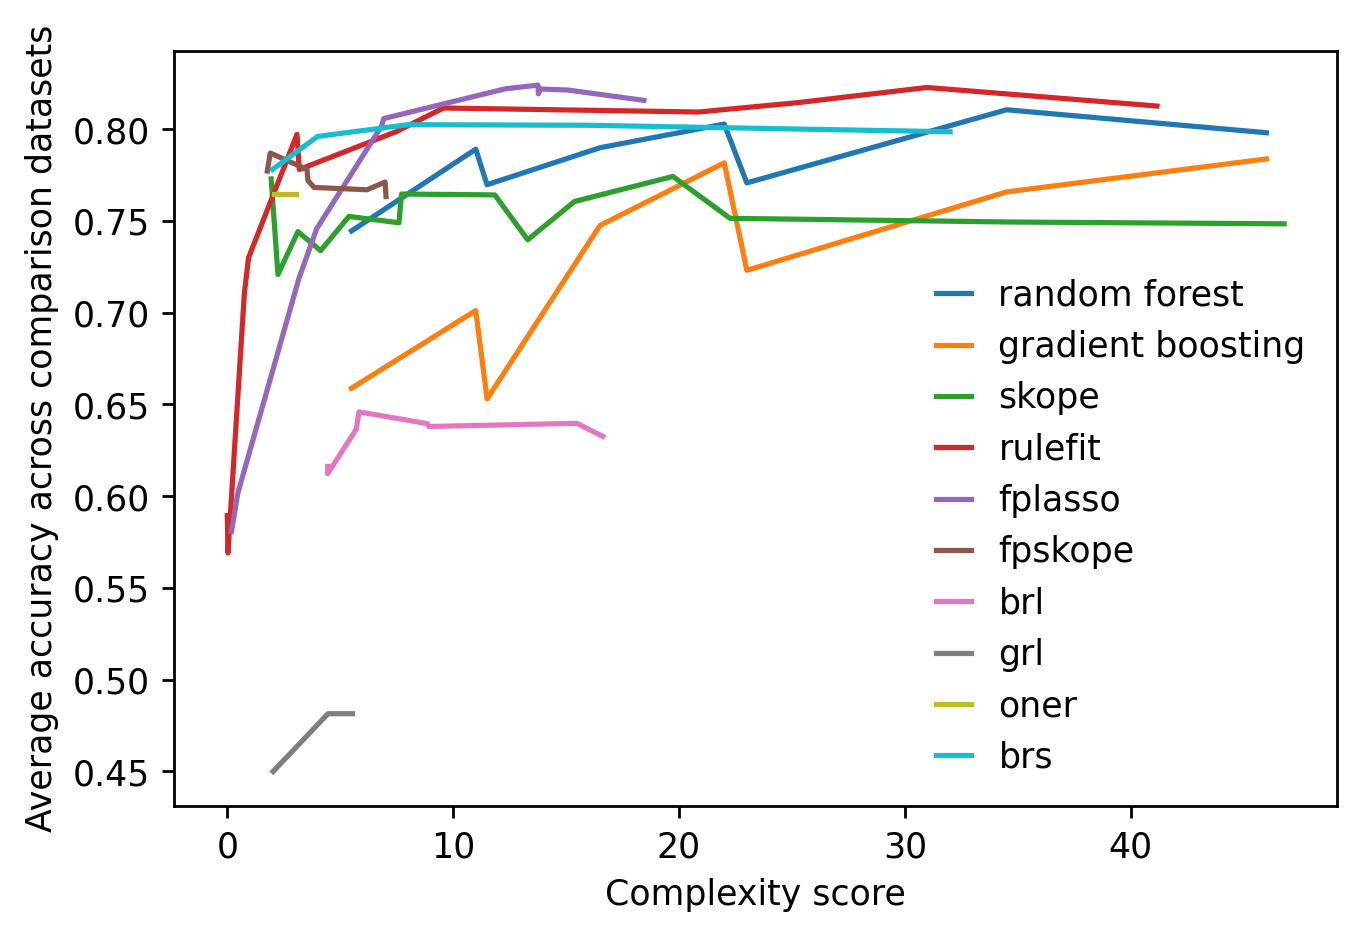

In [4]:
est_rf = [
    ('random_forest', RandomForestClassifier(n_estimators=n, max_depth=d)) 
    for n, d in itertools.product([2, 3, 4], [2, 3])
]
est_gb = [
    ('gradient_boosting', GradientBoostingClassifier(n_estimators=n, max_depth=d)) 
    for n, d in itertools.product([2, 3, 4], [2, 3])
]
est_skope = [
        ('skope', imodels.SkopeRulesClassifier(n_estimators=n, max_depth=d)) 
        for n, d in itertools.product([2, 4, 8, 16, 32, 64, 96], [2, 3])
    ]
est_rulefit = [
    ('rulefit', imodels.RuleFitClassifier(max_rules=n, tree_size=d)) 
    for n, d in itertools.product([2, 4, 8, 16, 32, 48], [4, 8])
]
est_fplasso = [
    ('fplasso', imodels.FPLassoClassifier(max_rules=n, maxcardinality=c)) 
    for n, c in itertools.product([2, 4, 8, 16, 32, 48, 96], [2, 3])
]
est_fpskope = [
    ('fpskope', imodels.FPSkopeClassifier(maxcardinality=c,  max_depth_duplication=dd))
    for c, dd in itertools.product([2, 3, 4], [1, 2, 3])
]
est_brl = [
    ('brl', imodels.BayesianRuleListClassifier(listlengthprior=l, maxcardinality=c)) 
    for l, c in itertools.product([2, 4, 8, 16], [2, 3])
]
est_grl = [('grl', imodels.GreedyRuleListClassifier(max_depth=d)) for d in [2, 4, 8, 16]]
est_oner = [('oner', imodels.OneRClassifier(max_depth=d)) for d in [2, 3, 4, 5, 6, 7]]
est_brs = [('brs', imodels.BoostedRulesClassifier(n_estimators=n)) for n in [2, 4, 8, 16, 32]]

ests = [est_rf, est_gb, est_skope, est_rulefit, est_fplasso, est_fpskope, est_brl, est_grl, est_oner, est_brs]
plt.figure(dpi=250)
for est in tqdm(ests):
    result = get_comparison_df(est)
    complexities = result[result.index.str.contains('Complexity')]
    accuracies = result[result.index.str.contains('Acc')]
    complexity_sort_indices = complexities.argsort()
    
    plt.plot(complexities[complexity_sort_indices],
             accuracies[complexity_sort_indices], label=est[0][0].replace('_', ' '))
plt.xlabel('Complexity score')
plt.ylabel('Average accuracy across comparison datasets')
plt.legend(frameon=False, handlelength=1)
plt.show()